<a href="https://colab.research.google.com/github/Jasmeet0810/Depression-Detection-Using-Time-Series-Model/blob/main/CNN_LSTM_Model_RP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


Mounted at /content/drive


##Load dataset

In [ ]:

file_path = "/content/drive/MyDrive/s_Normalizedfeatures/s_Normalizedfeatures.csv"
df = pd.read_csv(file_path)


# Inspect
print(df.info())
print(df.head())

# Split features and label
X = df.drop('MDD', axis=1)
y = df['MDD']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Columns: 205 entries, Activity to MDD
dtypes: float64(204), int64(1)
memory usage: 2.3 MB
None
   Activity  Mobility  Complexity  Kurtosis  2nd Difference Mean  \
0 -0.191337  0.021648    0.303478 -0.747865            -0.261044   
1 -0.119659  0.239980    0.410906 -0.278411            -0.345729   
2  0.071172 -0.626666   -0.463965 -0.095808             0.807396   
3 -0.222190 -0.738025   -0.124446 -0.518475            -1.386891   
4 -0.202497  1.731718   -0.703268 -0.578845             0.597487   

   2nd Difference Max  Coeffiecient of Variation  Skewness  \
0           -0.404863                   0.070799  0.505513   
1           -0.399872                  -0.004428  0.704773   
2            0.801863                   0.100766  0.956771   
3           -0.967224                   0.086890 -0.985196   
4            0.134010                   0.006627 -0.070061   

   1st Difference Mean  1st Difference Max  ...  

##Feature Scaling

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Variance Threshold Feature Selection
selector = VarianceThreshold(threshold=0.01)
X_variance = selector.fit_transform(X_scaled)

# Perturbation: Add Gaussian noise
noise = np.random.normal(0, 0.01, X_scaled.shape)
X_perturb = X_scaled + noise


##Reshape inputs for CNN-LSTM

In [ ]:
# (samples, timesteps, features)
X_train_var, X_test_var, y_train_var, y_test_var = train_test_split(X_variance, y, test_size=0.2, random_state=42)
X_train_var = X_train_var.reshape((X_train_var.shape[0], X_train_var.shape[1], 1))
X_test_var = X_test_var.reshape((X_test_var.shape[0], X_test_var.shape[1], 1))
y_train_var_cat = to_categorical(y_train_var)
y_test_var_cat = to_categorical(y_test_var)

X_train_pert, X_test_pert, y_train_pert, y_test_pert = train_test_split(X_perturb, y, test_size=0.2, random_state=42)
X_train_pert = X_train_pert.reshape((X_train_pert.shape[0], X_train_pert.shape[1], 1))
X_test_pert = X_test_pert.reshape((X_test_pert.shape[0], X_test_pert.shape[1], 1))
y_train_pert_cat = to_categorical(y_train_pert)
y_test_pert_cat = to_categorical(y_test_pert)


##Build CNN-LSTM model

In [ ]:

def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),  # Helps with convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.4),  # Slightly more dropout for small batches

        LSTM(64, return_sequences=False),
        BatchNormalization(),

        Dense(32, activation='relu'),
        Dropout(0.4),

        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

##Train model on variance features

In [ ]:

model_var = build_cnn_lstm_model((X_train_var.shape[1], 1))
history_var = model_var.fit(X_train_var, y_train_var_cat, epochs=80, batch_size=4, validation_split=0.1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.5271 - loss: 0.9004 - val_accuracy: 0.6239 - val_loss: 0.6328
Epoch 2/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.5737 - loss: 0.7448 - val_accuracy: 0.7692 - val_loss: 0.5000
Epoch 3/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6172 - loss: 0.6575 - val_accuracy: 0.7350 - val_loss: 0.5118
Epoch 4/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.6558 - loss: 0.6292 - val_accuracy: 0.7949 - val_loss: 0.4569
Epoch 5/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.6865 - loss: 0.6174 - val_accuracy: 0.7778 - val_loss: 0.4871
Epoch 6/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.6561 - loss: 0.6179 - val_accuracy: 0.7863 - val_loss: 0.4656
Epoch 7/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.6981 - loss: 0.5642 - val_accuracy: 0.8291 - val_loss: 0.4478
Epoch 8/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.6590 - loss: 0.6230 - 

##Train model on perturbed features

In [ ]:

model_pert = build_cnn_lstm_model((X_train_pert.shape[1], 1))
history_pert = model_pert.fit(X_train_pert, y_train_pert_cat, epochs=80, batch_size=4, validation_split=0.1)


Epoch 1/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5458 - loss: 0.8568 - val_accuracy: 0.6838 - val_loss: 0.6314
Epoch 2/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.5230 - loss: 0.7571 - val_accuracy: 0.7009 - val_loss: 0.5445
Epoch 3/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.6427 - loss: 0.6324 - val_accuracy: 0.8034 - val_loss: 0.4805
Epoch 4/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.6455 - loss: 0.6375 - val_accuracy: 0.7949 - val_loss: 0.4603
Epoch 5/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.6707 - loss: 0.6162 - val_accuracy: 0.6581 - val_loss: 0.5496
Epoch 6/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.6251 - loss: 0.6324 - val_accuracy: 0.8462 - val_loss: 0.4518
Epoch 7/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.6273 - loss: 0.6466 - val_accuracy: 0.8205 - val_loss: 0.4659
Epoch 8/80
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.6704 - loss: 0.5891 - 

##Evaluation function

In [ ]:

def evaluate_model(model, X_test, y_test, y_test_cat, title):
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    print(f"\n {title} - Classification Report")
    print(classification_report(y_test, y_pred_classes, digits=4))

    acc = accuracy_score(y_test, y_pred_classes)
    print(f" {title} - Accuracy: {acc * 100:.2f}%")

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

##Evaluate both models

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

 Variance Model - Classification Report
              precision    recall  f1-score   support

           0     0.8769    0.8085    0.8413       141
           1     0.8333    0.8940    0.8626       151

    accuracy                         0.8527       292
   macro avg     0.8551    0.8513    0.8520       292
weighted avg     0.8544    0.8527    0.8523       292

 Variance Model - Accuracy: 85.27%


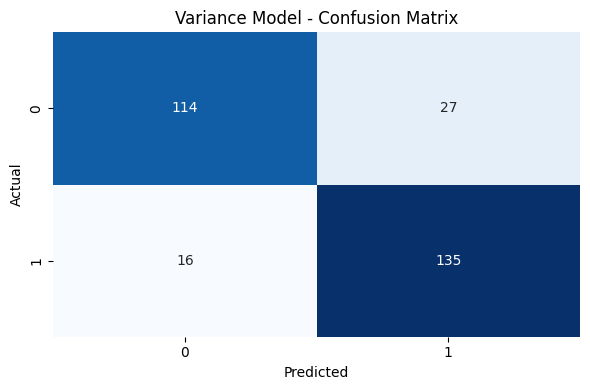

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

 Perturbation Model - Classification Report
              precision    recall  f1-score   support

           0     0.8289    0.8936    0.8601       141
           1     0.8929    0.8278    0.8591       151

    accuracy                         0.8596       292
   macro avg     0.8609    0.8607    0.8596       292
weighted avg     0.8620    0.8596    0.8596       292

 Perturbation Model - Accuracy: 85.96%


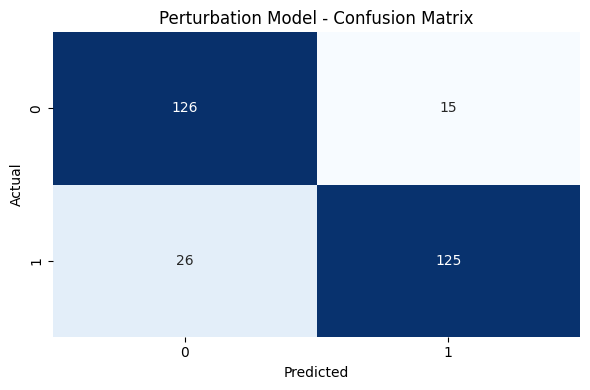

In [ ]:

evaluate_model(model_var, X_test_var, y_test_var, y_test_var_cat, "Variance Model")
evaluate_model(model_pert, X_test_pert, y_test_pert, y_test_pert_cat, "Perturbation Model")


##Classification report from model_var

In [ ]:

y_pred_probs = model_var.predict(X_test_var)
y_pred = np.argmax(y_pred_probs, axis=1)
print("Classification Report:")
print(classification_report(y_test_var, y_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       141
           1       0.83      0.89      0.86       151

    accuracy                           0.85       292
   macro avg       0.86      0.85      0.85       292
weighted avg       0.85      0.85      0.85       292



##Plot training/validation loss

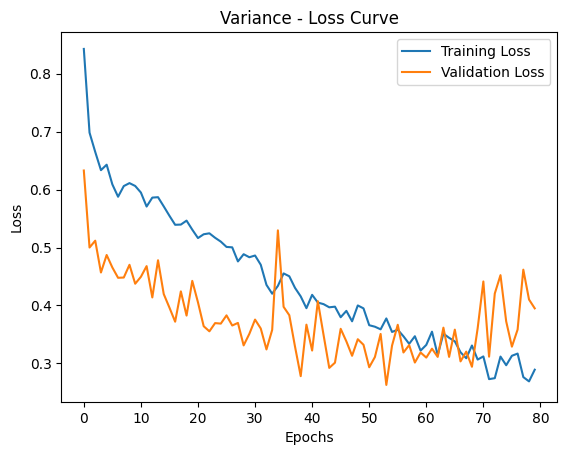

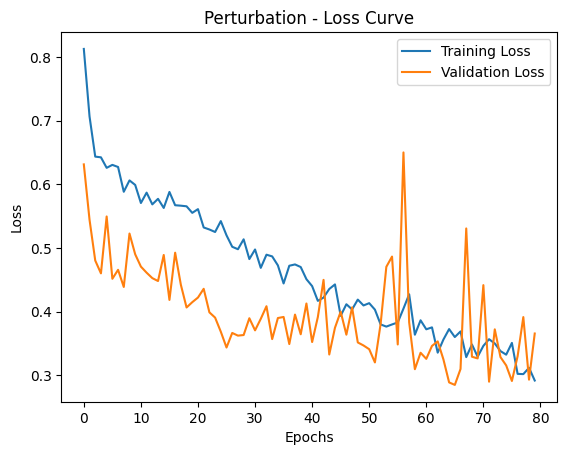

In [ ]:

def plot_loss(history, title):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history_var, "Variance")
plot_loss(history_pert, "Perturbation")

**Perturbation Model Accuracy Curve**

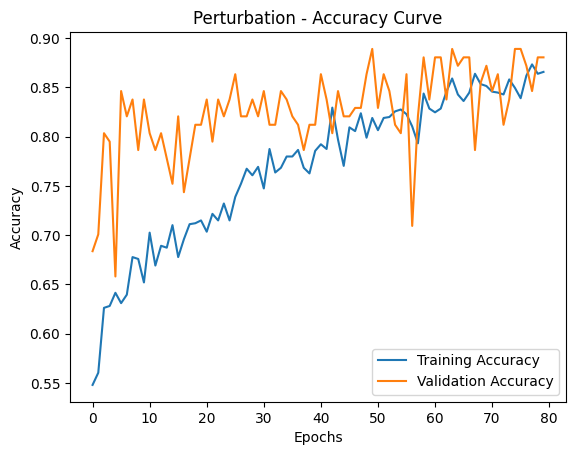

In [ ]:
def plot_accuracy(history, title):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(history_pert, "Perturbation")


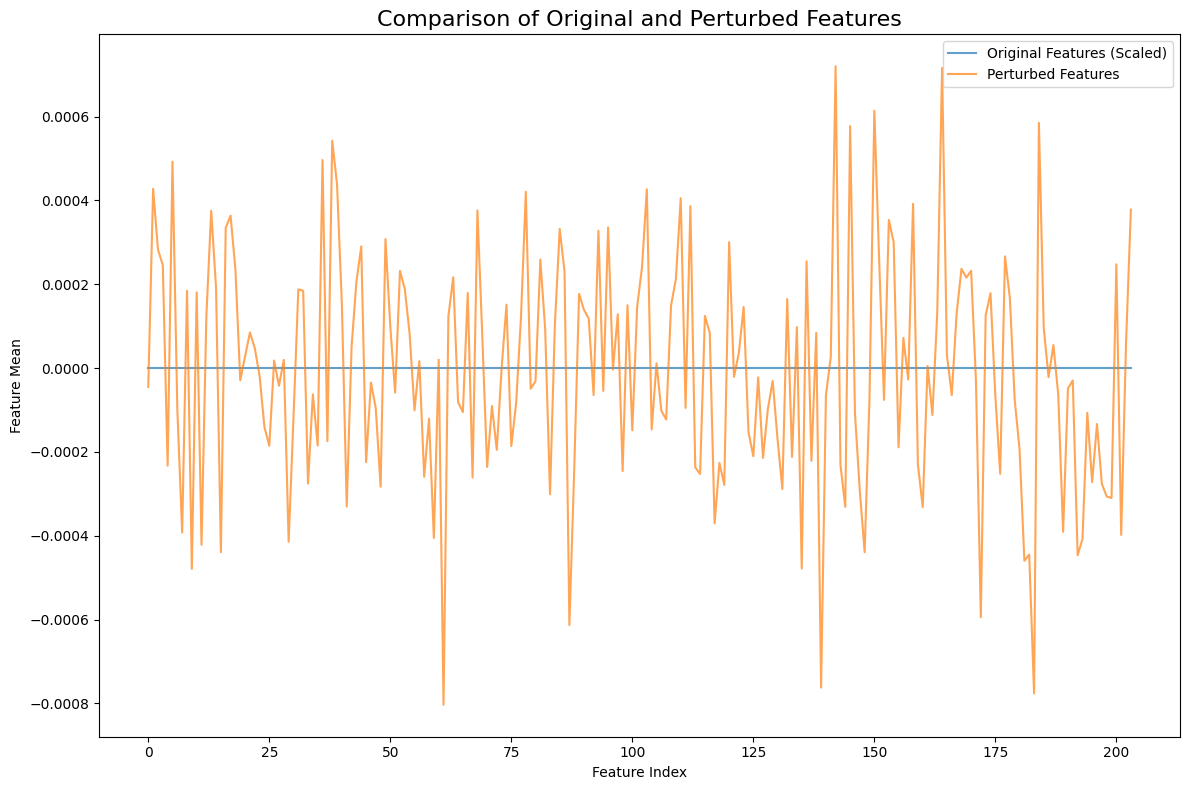

In [ ]:
# Visualizing the change between the original features and perturbed features
import matplotlib.pyplot as plt

# Calculate the mean of features before and after perturbation
mean_X_scaled = np.mean(X_scaled, axis=0)
mean_X_perturb = np.mean(X_perturb, axis=0)

# Plot the comparison
plt.figure(figsize=(12, 8))
plt.plot(mean_X_scaled, label='Original Features (Scaled)', alpha=0.7)
plt.plot(mean_X_perturb, label='Perturbed Features', alpha=0.7)
plt.title('Comparison of Original and Perturbed Features', fontsize=16)
plt.xlabel('Feature Index')
plt.ylabel('Feature Mean')
plt.legend()
plt.tight_layout()
plt.show()


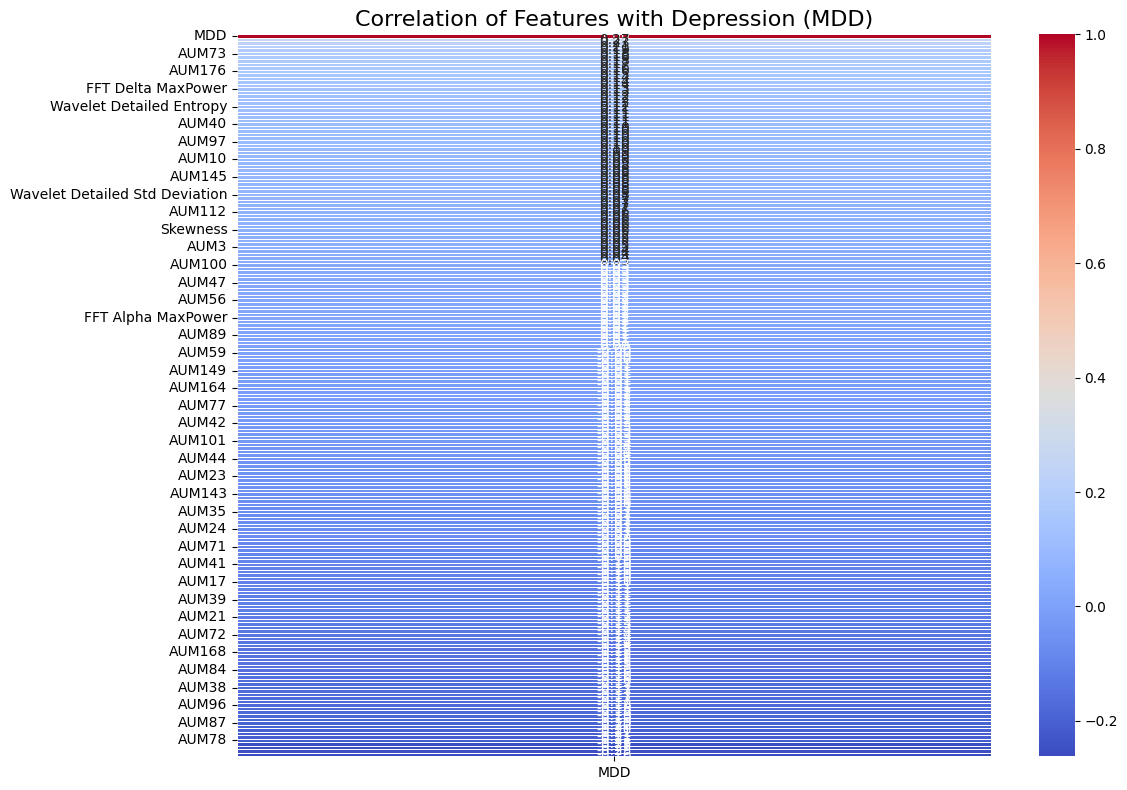

In [ ]:
# Correlation Matrix
import seaborn as sns

# Calculate correlation between features and target variable
corr_matrix = pd.concat([X, y], axis=1).corr()

# Plot the correlation matrix for all features with the target variable ('MDD')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['MDD']].sort_values(by='MDD', ascending=False), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation of Features with Depression (MDD)', fontsize=16)
plt.tight_layout()
plt.show()